In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def folder_image_count(path):
  main_dir='/content/drive/MyDrive/ Image_captioning/'+path
  d={}
  for dir in os.listdir(main_dir):
    d[dir]=len(os.listdir(os.path.join(main_dir,dir)))
  return d

In [4]:
train_image_count=folder_image_count('Train')
train_image_count

{'airplane': 503,
 'car': 672,
 'cat': 614,
 'dog': 486,
 'flower': 585,
 'fruit': 695,
 'motorbike': 546,
 'person': 685}

In [5]:
test_image_count=folder_image_count('Test')
test_image_count

{'airplane': 104,
 'car': 140,
 'cat': 127,
 'dog': 100,
 'flower': 121,
 'fruit': 145,
 'motorbike': 113,
 'person': 142}

In [6]:
cv_image_count=folder_image_count('Cv')
cv_image_count

{'airplane': 104,
 'car': 140,
 'cat': 127,
 'dog': 100,
 'flower': 121,
 'fruit': 145,
 'motorbike': 113,
 'person': 142}

In [7]:
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,BatchNormalization,GlobalAvgPool2D
from keras.models import Model,load_model
from keras.preprocessing.image import load_img,ImageDataGenerator,img_to_array
from keras.applications.mobilenet import MobileNet ,preprocess_input
import keras

In [8]:
batch_size=32
def preprocess_images(path):
  img_data = ImageDataGenerator(preprocessing_function=preprocess_input)
  img =  img_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=batch_size)
  return img

In [9]:
train_data=preprocess_images("/content/drive/MyDrive/ Image_captioning/Train")

Found 4786 images belonging to 8 classes.


In [10]:
train_data.class_indices

{'airplane': 0,
 'car': 1,
 'cat': 2,
 'dog': 3,
 'flower': 4,
 'fruit': 5,
 'motorbike': 6,
 'person': 7}

In [11]:
cv_data=preprocess_images("/content/drive/MyDrive/ Image_captioning/Cv")

Found 992 images belonging to 8 classes.


In [12]:
test_data=preprocess_images("/content/drive/MyDrive/ Image_captioning/Test")

Found 992 images belonging to 8 classes.


In [13]:
base_model = MobileNet(input_shape=(224,224,3),include_top=False) 

In [14]:
for layer in base_model.layers:
  layer.trainable = False

In [15]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [16]:
#add few layers after the base model
x=Flatten()(base_model.output)
x=Dense(units=8,activation='sigmoid')(x)

model=Model(base_model.input,x)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [18]:
model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [19]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=4,restore_best_weights=True,mode='max')
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/ Image_captioning/best_model_transfer_learning.h5',mode='max',save_best_only=True)
cb=[early_stopping,model_checkpoint]

In [20]:
no_epoches=50
hs=model.fit_generator(generator=train_data,steps_per_epoch=len(train_data),
                        epochs=no_epoches,validation_data=cv_data,validation_steps=len(cv_data),callbacks=cb)

Epoch 1/50
150/150 [==============================] - 1665s 11s/step - loss: 1.0105 - accuracy: 0.9086 - val_loss: 0.2223 - val_accuracy: 0.9869
Epoch 2/50
150/150 [==============================] - 19s 125ms/step - loss: 0.0585 - accuracy: 0.9939 - val_loss: 0.2432 - val_accuracy: 0.9849
Epoch 3/50
150/150 [==============================] - 19s 123ms/step - loss: 0.1043 - accuracy: 0.9933 - val_loss: 0.2231 - val_accuracy: 0.9919
Epoch 4/50
150/150 [==============================] - 18s 122ms/step - loss: 0.0141 - accuracy: 0.9989 - val_loss: 0.2392 - val_accuracy: 0.9889
Epoch 5/50
150/150 [==============================] - 18s 122ms/step - loss: 0.0227 - accuracy: 0.9972 - val_loss: 0.4415 - val_accuracy: 0.9849


In [21]:
h=hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy vs validation Accuracy')

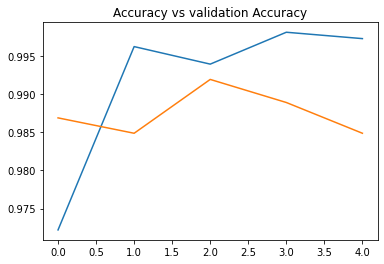

In [22]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'])
plt.title('Accuracy vs validation Accuracy')

Text(0.5, 1.0, 'Loss vs validation Loss')

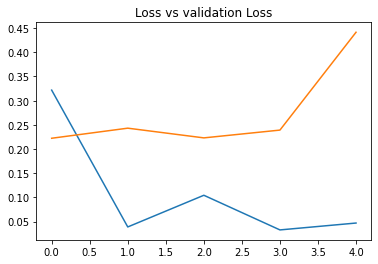

In [23]:
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('Loss vs validation Loss')

In [24]:
m=model.evaluate_generator(train_data)
print('Train log loss is : ',m[0])
print('Train accuracy is : ',m[1])

print('-'*30)
m=model.evaluate_generator(cv_data)
print('Cv log loss is : ',m[0])
print('Cv accuracy is : ',m[1])

print('-'*30)
m=model.evaluate_generator(test_data)
print('Test log loss is : ',m[0])
print('Test accuracy is : ',m[1])

Train log loss is :  0.08806650340557098
Train accuracy is :  0.9920601844787598
------------------------------
Cv log loss is :  0.22230006754398346
Cv accuracy is :  0.9868951439857483
------------------------------
Test log loss is :  0.2234114706516266
Test accuracy is :  0.9879032373428345


In [25]:
# from keras.models import load_model
# model = load_model('/content/drive/MyDrive/ Image_captioning/best_model.h5')

In [26]:
def predict_class(c):#index to image class
  for i,j in train_data.class_indices.items():
    if j==c:
      return i
  return -1 

# Sample outputs from test data

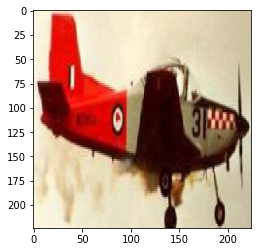

Image predicted by the model is airplane


In [27]:
path='/content/drive/MyDrive/ Image_captioning/Test/airplane/airplane_0001.jpg'
image=load_img(path,target_size=(224,224))
image_array=img_to_array(image)/255

plt.imshow(image_array)
plt.show()

image_array=np.expand_dims(image_array,axis=0)
c=np.argmax(model.predict(image_array))
print('Image predicted by the model is',predict_class(c))

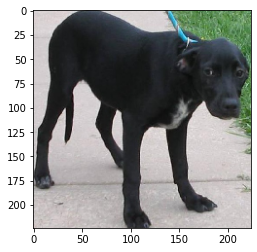

Image predicted by the model is dog


In [28]:
path='/content/drive/MyDrive/ Image_captioning/Test/dog/dog_0023.jpg'
image=load_img(path,target_size=(224,224))
image_array=img_to_array(image)/255

plt.imshow(image_array)
plt.show()

image_array=np.expand_dims(image_array,axis=0)
c=np.argmax(model.predict(image_array))
print('Image predicted by the model is',predict_class(c))

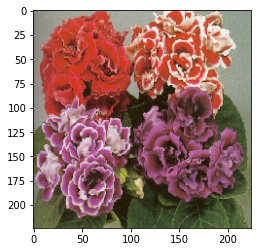

Image predicted by the model is flower


In [29]:
path='/content/drive/MyDrive/ Image_captioning/Test/flower/flower_0004.jpg'
image=load_img(path,target_size=(224,224))
image_array=img_to_array(image)/255

plt.imshow(image_array)
plt.show()

image_array=np.expand_dims(image_array,axis=0)
c=np.argmax(model.predict(image_array))
print('Image predicted by the model is',predict_class(c))

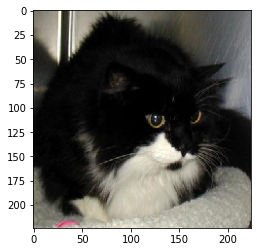

Image predicted by the model is cat


In [30]:
path='/content/drive/MyDrive/ Image_captioning/Test/cat/cat_0050.jpg'
image=load_img(path,target_size=(224,224))
image_array=img_to_array(image)/255

plt.imshow(image_array)
plt.show()

image_array=np.expand_dims(image_array,axis=0)
c=np.argmax(model.predict(image_array))
print('Image predicted by the model is',predict_class(c))